In [207]:
%matplotlib inline
import torch
from utils import load_mnist, show_results, ModelTrainer
from checker import test_droput, test_bn


torch.manual_seed(44)

train_dataset = load_mnist(train=True, shrinkage=0.01)
test_dataset = load_mnist(train=False, shrinkage=0.1)

In [208]:
n_epochs = 300
learning_rate = 0.05
batch_size = 128

trainer = ModelTrainer(train_dataset, test_dataset, batch_size=batch_size)

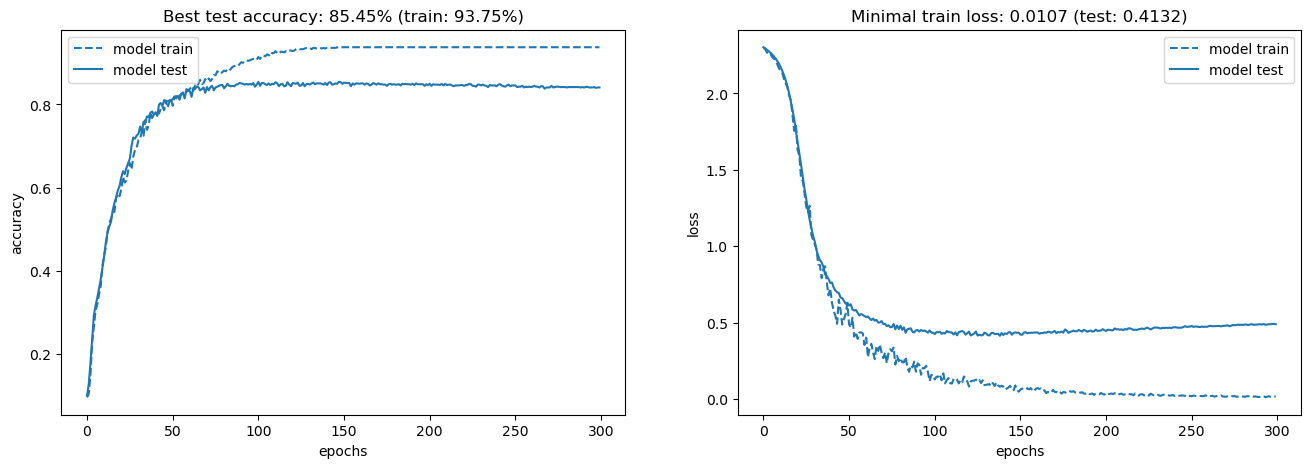

In [3]:
model = torch.nn.Sequential(torch.nn.Linear(784, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 10))

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=history)

In [4]:
# Zadanie 1
#
# 1. Neurony uczą się niezależnie od swojego otoczenia i w konsekwencji sztywne dopasowanie do danych treningowych jest
# mniej prawdopodobne
# 2. Wolniej się wypłaszcza w przypadku z dropoutem
# 3. Podzbiór sieci neuronowej jest siecią neuronową a wyjściowa sieć jest sumą swoich podzbiorów
# 4. Ponieważ sieć jest nauczona, że nie wszystkie jej neurony są aktywne a chcemy żeby wartość oczekiwana output z danej
# warstwy była taka sama

In [209]:
class Dropout(torch.nn.Module):

    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            tmp = torch.bernoulli(self.p * torch.ones(size=(x.size()[1],)))
            return (x * tmp)/self.p

        else:
            return x

In [210]:
test_droput(Dropout)

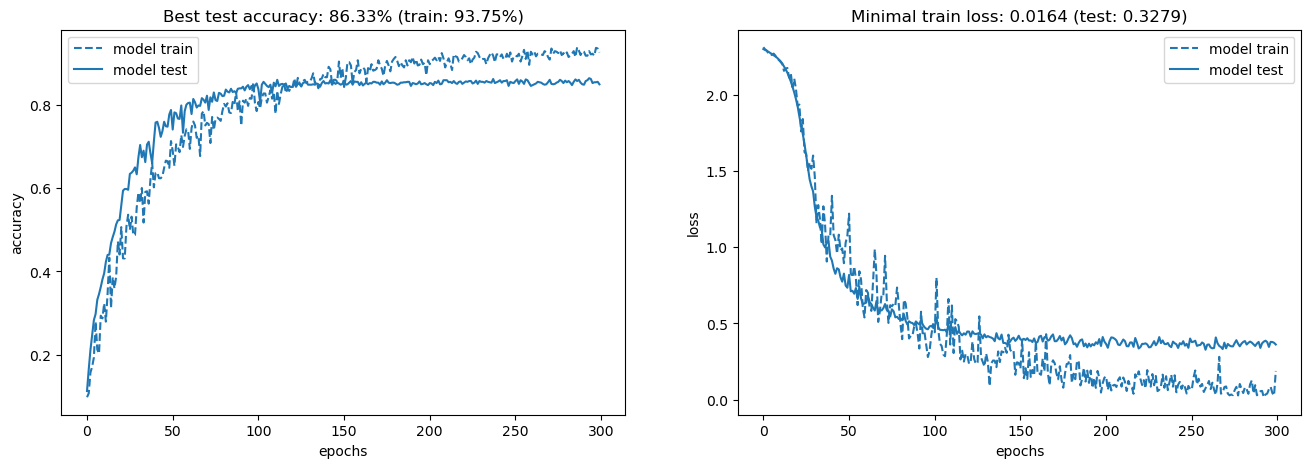

In [114]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    Dropout(0.5),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    Dropout(0.5),
    torch.nn.Linear(256, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
dropout_history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=dropout_history)

In [ ]:
# Zadanie 2 - pytania
# 1. Przy |x| -> infinity pochodna sigmoidy zbiega do zera, a batch-normalizacja zapewnia, że |x| jest ograniczony
# 2.
# 3. W obrębie mini-batchu dany przykład po normalizacji jest zależny od pozostałych przykładów, więc overfitting
# jest mniej prawdopodobny

In [213]:
class BatchNorm(torch.nn.Module):

    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm, self).__init__()

        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.sigma = 1.
        self.mu = 1.

        self.gamma = torch.nn.parameter.Parameter(data=torch.Tensor((1.0,)), requires_grad=True)
        self.beta = torch.nn.parameter.Parameter(data=torch.Tensor((0.,)), requires_grad=True)

    def forward(self, x):
        if self.training:
            mi_B = torch.mean(input=x, dim=(1,))
            var_B = torch.var(x, dim=(1,))
            self.sigma = (1 - self.momentum)*self.sigma + self.momentum*var_B
            self.mu = (1 - self.momentum)*self.mu + self.momentum*mi_B
            out_x = (x - mi_B[:, None])/torch.sqrt(var_B[:, None] + self.eps)

            return self.gamma * out_x + self.beta

        else:
            out_x = (x - self.mu[:, None])/torch.sqrt(self.sigma[:, None] + self.eps)
            return self.gamma * out_x + self.beta

In [214]:
torch.manual_seed(42)
bn = BatchNorm(num_features=100)

opt = torch.optim.SGD(bn.parameters(), lr=0.1)

bn.train()
x = torch.rand(20, 100)
out = bn(x)

assert out.mean().abs().item() < 1e-4
assert abs(out.var().item() - 1) < 1e-1

assert (bn.sigma != 1).all()
assert (bn.mu != 1).all()

loss = 1 - out.mean()
loss.backward()
opt.step()

assert (bn.beta != 0).all()

n_steps = 10

for i in range(n_steps):
    x = torch.rand(20, 100)
    out = bn(x)
    loss = 1 - out.mean()
    loss.backward()
    opt.step()


torch.manual_seed(43)
test_x = torch.randn(20, 100)
bn.eval()
test_out = bn(test_x)
assert abs(test_out.mean() + 0.5) < 1e-1

AssertionError: 